In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Question 1: Exploring the data - 30 points
In this part, you will explore the data to address the curiosities of the demanding Professor Oak.

1. (6 points) Explore the data and report some descriptive statistics (e.g., use df.describe(), report the number of classes, summarize the attack and defense distributions, etc.). This will be useful later in your analysis.
2. (4 points) Compare the probability distribution of the “regular attack” feature with that of the “regular defense” feature. In particular,
   1. visualize the relation between these two variables using an appropriate plot;
   2. list the names of the 3 Pokémon with highest attack-over-defense ratio;
   3. list the names of the 3 Pokémon with lowest attack-over-defense ratio;
   4. list the names of the 10 Pokémon with the largest number of victories.
3. (10 points) Professor Oak suspects that Pokémon in the _grass_ class have a stronger regular attack than those in the _rock_ class. Check if he is right and convince him of your conclusion with statistical arguments.
   Note: If there are Pokémon that are in both classes, discard them.
   Note: You may assume that the distribution of the regular attack feature is normal for all Pokémon classes.
4. (10 points) Professor Oak reveals to you that he has built a backdoor into every Pokedex in the world and that he is secretly dumping the memory of all devices to his servers. He expects to have the records of 1 billion combats soon, and one machine won’t be enough to handle all this data, so he wants you to use Spark. Your task: Solve problem 2iv above (“list the names of the 10 Pokémon with the largest number of victories”) with a Spark implementation in Python. The output should be a Python list with 10 names sorted in descending order of number of victories.
   Note: You don’t need to run the Spark code -- just list it! You should assume that you have two DataFrames (already loaded) called `pokemon` and `combats`, with the same schema as the small CSV files you’ve been working with above.

In [2]:
df_pokemon = pd.read_csv('pokemon.csv')
df_combats = pd.read_csv('combats.csv')

In [3]:
display(df_pokemon.head())
display(df_combats.head())

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False


,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [4]:
display(df_pokemon.describe())
display(df_combats.describe())

,pid,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


,First_pokemon,Second_pokemon,Winner
count,50000.000000,50000.000000,50000.000000
mean,400.495640,403.159660,408.890100
std,229.549429,230.083644,231.159961
min,1.000000,1.000000,1.000000
25%,203.000000,207.000000,206.000000
50%,399.000000,402.000000,422.000000
75%,597.250000,602.000000,606.000000
max,800.000000,800.000000,800.000000


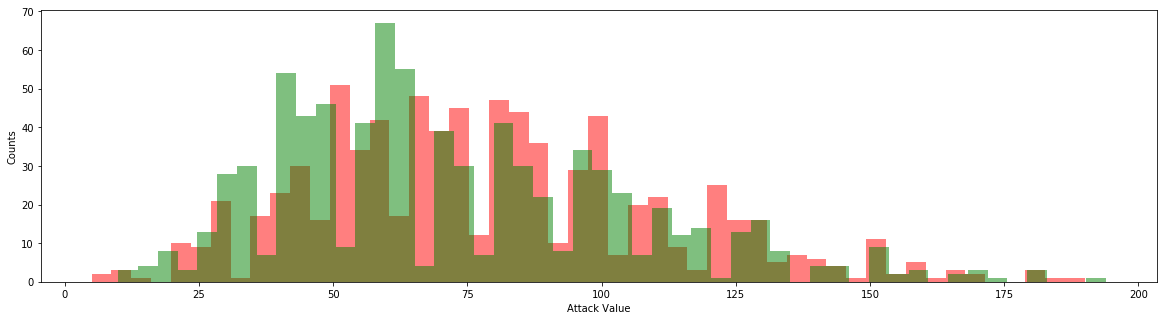

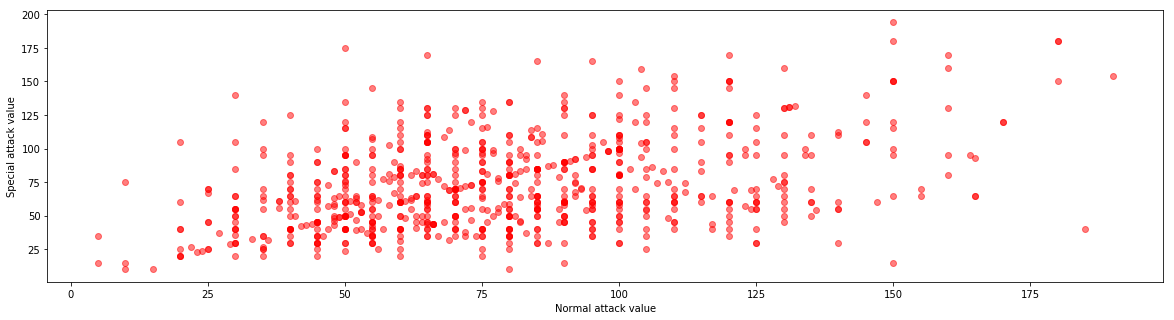

In [5]:
figure = plt.figure(figsize = (20, 5))
plt.hist(df_pokemon.Attack, color = 'r', alpha = 0.5, bins = 50)
plt.hist(df_pokemon['Sp. Atk'], color = 'g', alpha = 0.5, bins = 50)
plt.xlabel('Attack Value')
plt.ylabel('Counts')
plt.show()

figure = plt.figure(figsize = (20, 5))
plt.scatter(df_pokemon.Attack, df_pokemon['Sp. Atk'], color = 'r', alpha = 0.5)
plt.xlabel('Normal attack value')
plt.ylabel('Special attack value')
plt.show()

In [6]:
df_pokemon['att_def_ratio'] = (df_pokemon.Attack/df_pokemon.Defense)
df_pokemon = df_pokemon.sort_values(by = 'att_def_ratio', ascending = False)

print('\nTop 3 Pokémon with highest attack-over-defense ratio:')
display(df_pokemon.Name.iloc[0:3].tolist())

print('\nTop 3 Pokémon with lowest attack-over-defense ratio:')
display(df_pokemon.Name.iloc[-3:].tolist())




Top 3 Pokémon with highest attack-over-defense ratio:


['DeoxysAttack Forme', 'Carvanha', 'Mega Beedrill']


Top 3 Pokémon with lowest attack-over-defense ratio:


['Bronzor', 'Magikarp', 'Shuckle']

In [7]:
pokemons_ids = pd.DataFrame(df_pokemon.groupby('pid')['Name'].apply(lambda x: x)).reset_index().sort_values(by = 'index')
pokemons_ids.columns = ['PID', 'Name']

map_dict = {}
for _, row in pokemons_ids.iterrows():
    map_dict.update({row.PID:row.Name})
    
df_combats['winner_name'] = df_combats['Winner'].map(map_dict)
display(df_combats.head())

top_winners = pd.DataFrame(df_combats.groupby('winner_name').apply(len), 
                           columns = ['nb_victories']).reset_index().sort_values(by = 'nb_victories', ascending = False)

print('\nThe names of the 10 Pokémon with the largest number of victories are:')
display(top_winners.iloc[0:10].reset_index(drop = True))

,First_pokemon,Second_pokemon,Winner,winner_name
0,266,298,298,Shiftry
1,702,701,701,Virizion
2,191,668,668,Litwick
3,237,683,683,Golett
4,151,231,151,Kabuto



The names of the 10 Pokémon with the largest number of victories are:


,winner_name,nb_victories
0,Mega Mewtwo X,152
1,Piplup,136
2,Mega Aerodactyl,136
3,Deoxys Normal Forme,134
4,Turtwig,133
5,Nincada,133
6,Wynaut,130
7,Slowking,130
8,Kingdra,128
9,Snorlax,127


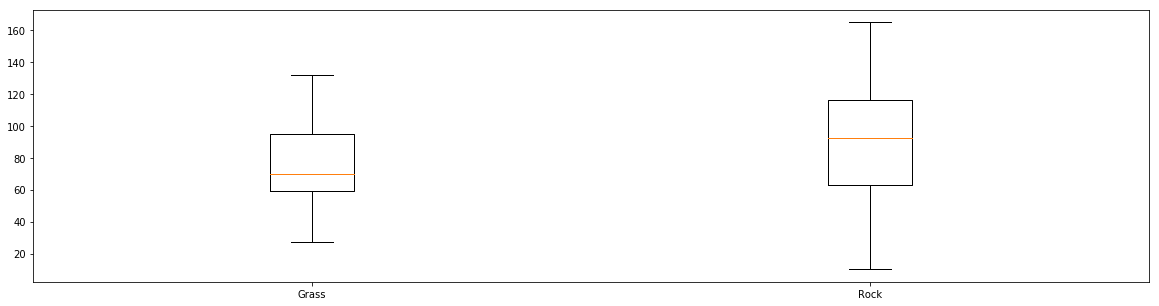

In [8]:
pokemon_grass = df_pokemon[(df_pokemon['Class 1'] == 'Grass') | (df_pokemon['Class 2'] == 'Grass')]
pokemon_rock  = df_pokemon[(df_pokemon['Class 1'] == 'Rock') | (df_pokemon['Class 2'] == 'Rock')]

common_pids   = list(set(pokemon_grass.pid.tolist()) & set(pokemon_rock.pid.tolist()))

pokemon_grass = pokemon_grass[~pokemon_grass.pid.isin(common_pids)]
pokemon_rock  = pokemon_rock[~pokemon_rock.pid.isin(common_pids)]

figure = plt.figure(figsize = (20, 5))
plt.boxplot([pokemon_grass.Attack.tolist(), pokemon_rock.Attack.tolist()])
ax = plt.gca()
ax.set_xticklabels(['Grass', 'Rock'])
plt.show()

Professor Oak was not right, based on the stron statistics provided by the above boxplot!

## Question 2: Prediction - 40 points
Now that you know what your data looks like, you are ready to implement the prediction model for the Pokedex 2.0. The model should take as input the features of two Pokémon and generate a binary value to predict who will win.

1. (3 points) Generate the feature vectors and the labels to train your model.
2. (5 points) How does your model handle categorical features and Pokémon with multiple classes?
3. (10 points) Train a random forest to predict the winner of a match based on the available features. To do so, split the full dataset randomly into a training set (90%) and a testing set (10%), and try different values of the number of estimators (`n_estimators`, try values 10, 25, 50, 100) and the maximum tree depth (`max_depth`, try values 2, 4, 10). Do this manually, without using any scikit-learn helpers.
4. (5 points) Summarize and describe the results you obtain when training on 90% and testing on 10% of the data. What is the best combination of the two hyperparameters (number of estimators and maximum tree depth)?
5. (5 points) Could the above training/testing setup potentially lead to wrong conclusions regarding the best hyperparameter setting? If so, describe why, and how you would address the problem. (Hint: think about how you’re making use of the data during training and testing).
6. (7 points) Implement your solution to the problem you’ve identified in the previous subquestion (5), and show and describe your results.
7. (5 points) Finally, Professor Oak wants to know what the most predictive features are. Plot feature importance as a bar plot representing the 10 most predictive variables.

In [11]:
display(df_pokemon.head(2))

winner_list = []
for _, row in df_combats.iterrows():
    if row.Winner == row.First_pokemon:
        winner_list += [0]
    elif row.Winner == row.Second_pokemon:
        winner_list += [1]
df_combats['winner_binary'] = winner_list

display(df_combats.head(2))

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,att_def_ratio
429,430,DeoxysAttack Forme,Psychic,NaN,50,180,20,180,20,150,True,9.0
347,348,Carvanha,Water,Dark,45,90,20,65,20,65,False,4.5


,First_pokemon,Second_pokemon,Winner,winner_name,winner_binary
0,266,298,298,Shiftry,1
1,702,701,701,Virizion,1


In [15]:
print(df_combats.shape)

(50000, 5)


In [20]:
df_single_pokemon_features = df_pokemon.copy().drop(['att_def_ratio', 'Name'], axis = 1)
# convert classes into one-hot-label
df_single_pokemon_features = pd.get_dummies(df_single_pokemon_features, columns = ['Class 1', 'Class 2'], prefix = '', prefix_sep = '')
# remove duplicated columns
df_single_pokemon_features = df_single_pokemon_features.loc[:, ~df_single_pokemon_features.columns.duplicated()]
# map true/false of Legendary to 1/0
map_dict = {True : 1, False : 0}
df_single_pokemon_features.Legendary = df_single_pokemon_features.Legendary.map(map_dict)
# set pid as index for merging
df_single_pokemon_features = df_single_pokemon_features.set_index('pid')

display(df_single_pokemon_features.head(2))

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Bug,Dark,Dragon,...,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
pid,,,,,,,,,,,,,,,,,,,,,
430,50,180,20,180,20,150,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
348,45,90,20,65,20,65,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


- categorical features are encoded into one-hot-label format
- pokemon classess are also converted into one-hot-label. If more than one class is present, this means that the pokemon will have to non-zero values for two of those features converted into one-hot-label.

In [68]:
df_combat_features = df_combats.copy().drop(['Winner', 'winner_name'], axis = 1)

tmp = df_single_pokemon_features.copy()
tmp.columns = ['Pokemon0_' + i for i in tmp.columns]
df_combat_features = df_combat_features.merge(tmp, right_index = True, left_on = 'First_pokemon')

tmp = df_single_pokemon_features.copy()
tmp.columns = ['Pokemon1_' + i for i in tmp.columns]
df_combat_features = df_combat_features.merge(tmp, right_index = True, left_on = 'Second_pokemon')

labels             = df_combat_features.winner_binary.values
df_combat_features = df_combat_features.drop(['First_pokemon', 'Second_pokemon', 'winner_binary'], axis = 1).reset_index(drop = True)

df_combat_features.head(2)

,Pokemon0_HP,Pokemon0_Attack,Pokemon0_Defense,Pokemon0_Sp. Atk,Pokemon0_Sp. Def,Pokemon0_Speed,Pokemon0_Legendary,Pokemon0_Bug,Pokemon0_Dark,Pokemon0_Dragon,...,Pokemon1_Ghost,Pokemon1_Grass,Pokemon1_Ground,Pokemon1_Ice,Pokemon1_Normal,Pokemon1_Poison,Pokemon1_Psychic,Pokemon1_Rock,Pokemon1_Steel,Pokemon1_Water
0,50,64,50,45,50,41,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,70,80,50,35,35,35,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [70]:
n_est = [10, 25, 50, 100]
max_depth = [2, 4, 10]

msk = np.random.rand(len(df_combat_features)) < 0.9

train_set   = df_combat_features[msk]
train_label = labels[msk]
test_set    = df_combat_features[~msk]
test_label  = labels[~msk]

best_accuracy = 0
best_n = None
best_d = None

for n in n_est:
    for d in max_depth:
        model = RandomForestClassifier(n_estimators = n, max_depth = d)
        model.fit(train_set, train_label)
        prediction = model.predict(test_set)
        accuracy   = accuracy_score(test_label, prediction)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n = n
            best_d = d
        
print('The best accuracy is %f'%(best_accuracy))
print('For n_estimators     %f'%(best_n))
print('For max_depth        %f'%(best_d))

The best accuracy is 0.917170
For n_estimators     50.000000
For max_depth        10.000000


Potential problem with the above setup: 
- always the same train/test split is used! Should use bootstrap to be more robust. This is implemented in the next block of code.

In [42]:
best_accuracy = 0
best_n = None
best_d = None

n_boostrap = 10

for n in n_est:
    for d in max_depth:
        model = RandomForestClassifier(n_estimators = n, max_depth = d)
        tmp_avg = 0
        
        for b in range(n_boostrap):
            msk = np.random.rand(len(df_combat_features)) < 0.9
            train_set   = df_combat_features[msk]
            train_label = labels[msk]
            test_set    = df_combat_features[~msk]
            test_label  = labels[~msk]
            
            model.fit(train_set, train_label)
            prediction = model.predict(test_set)
            tmp_avg   += accuracy_score(test_label, prediction)
        
        tmp_avg /= n_boostrap
            
        if tmp_avg > best_accuracy:
            best_accuracy = accuracy
            best_n = n
            best_d = d
        
print('The best accuracy is %f'%(best_accuracy))
print('For n_estimators     %f'%(best_n))
print('For max_depth        %f'%(best_d))

The best accuracy is 0.909868
For n_estimators     100.000000
For max_depth        10.000000


Results are the same but with a more robust Accuracy estimation.

Another potential problem comes from the fact that the model performance evaluation is biased. In fact, the test set is used for both the hyperparameters tuning and the performance evaluation. Cross Validation should be used.

CV implementation (test: 0.1, train: 0.7, validation: 0.2):

In [71]:
n_est = [10, 25, 50, 100]
max_depth = [2, 4, 10]

msk = np.random.rand(len(df_combat_features)) < 0.7

train_set        = df_combat_features[msk]
train_label      = labels[msk]
tmp              = df_combat_features[~msk]
tmp_label        = labels[~msk]
div = int(len(tmp_label) * 0.2 * 0.1)
test_set         = tmp.iloc[div + 1:]
test_label       = tmp_label[div+1:]
validation_set   = tmp.iloc[0:div]
validation_label = tmp_label[0:div]

best_accuracy = 0
best_n = None
best_d = None

for n in n_est:
    for d in max_depth:
        model = RandomForestClassifier(n_estimators = n, max_depth = d)
        model.fit(train_set, train_label)
        prediction = model.predict(validation_set)
        accuracy   = accuracy_score(validation_label, prediction)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n = n
            best_d = d
            
best_model = RandomForestClassifier(n_estimators = best_n, max_depth = best_d).fit(test_set, test_label)
accuracy   = accuracy_score(test_label, model.predict(test_set))

print('The accuracy of the best model is %f'%(accuracy))
print('For n_estimators     %f'%(best_n))
print('For max_depth        %f'%(best_d))

The accuracy of the best model is 0.913574
For n_estimators     100.000000
For max_depth        10.000000


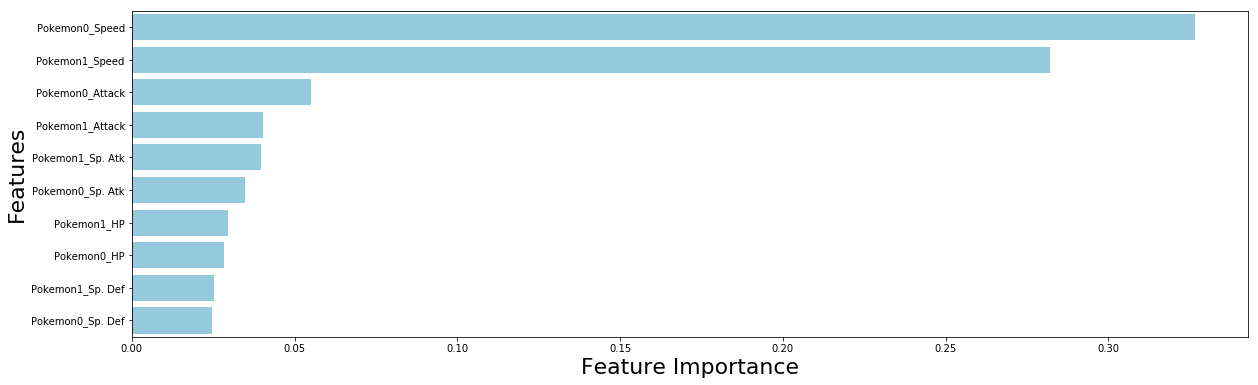

In [72]:
df_importance = pd.DataFrame({'feature':df_combat_features.columns.tolist(), 
                              'importance':best_model.feature_importances_}).sort_values('importance', ascending = False).reset_index(drop = True)


sns.barplot(x = 'importance', y = 'feature', color='skyblue', data = df_importance.iloc[0:10], orient = 'h', ci = 'sd', capsize=.2)
fig = plt.gcf()
fig.set_size_inches(20, 6)
plt.xlabel('Feature Importance', size = 22)
plt.ylabel('Features', size = 22)
plt.show()


## Question 3: Ranking - 30 points
Something the new Pokedex is missing is a smart way of ranking the Pokémon. As the dataset Professor Oak gave you contains the outcome of a large number of battles, the idea is to use this data to come up with a way of sorting the Pokémon from strongest to weakest.
1. (5 points) Compute the winning ratio (number of wins divided by number of battles) for all Pokémon. Show the 10 Pokémon with the highest ratio and describe what they have in common with respect to their features. Discuss your results about feature importance from question 2.7 (regarding feature importance) in this context.

Pokémon tournaments can be represented as a so-called _dominance graph_. The dominance graph is a directed graph in which each Pokémon is represented by one vertex, and directed edges point from stronger to weaker Pokémons: in particular, if Pokémon _i_ has won a strictly larger number of times against Pokémon _j_ than _j_ has won against _i_ (that is, if _i_ dominates _j_), there is a directed edge pointing from node _i_ to node _j_. The dominance graph can be represented as an adjacency matrix _G_ where entry _G_<sub>_ij_</sub> is 1 if there is an edge pointing from _i_ to _j_, and 0 otherwise.

2. (10 points) A simple method for identifying the strongest Pokémon using this graph is to compute the matrix _A_ = _G_ + _G_<sup>2</sup>. Consider a given row of _A_; summing up all elements of that row results in a dominance score for the respective Pokémon. Explain what this score represents and why it may be interpreted as capturing the dominance of a Pokémon.
3. (7 points) Compute _A_ and extract the 10 Pokémon with the highest dominance score.
4. (3 points) Compare the ranking by dominance scores with the ranking by winning ratio (cf. subquestion 1 above). What do you observe? How do you explain the differences (if any)?
5. (5 points) Professor Oak is really keen on featuring a solid ranking mechanism in the new Pokedex, so you need to make a decision: Which scoring method is better, that based on winning ratio or that based on dominance scores? Support your opinion with explanations and examples.